In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# **1. Object Detection**

**Load Data**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Defining datasets
key_points_data_path = '/content/gdrive/My Drive/AI_yeeun/Datasets/slist_landmarks_align_celeba.csv'
images_data_path = "/content/gdrive/My Drive/AI_yeeun/Datasets/celeba"

#Scaling the image
images_data_size = 19429
x_org = 178
y_org = 218
x_ = 100
image_size_ratio = x_org / y_org
y_ = int(image_size_ratio * x_)
original_image_size = (x_org, y_org)
new_image_size = (x_,y_)
image_size_training = new_image_size

In [ ]:
# load the dataset
df_org = pd.read_csv(key_points_data_path)
df_org = df_org[:images_data_size]

In [ ]:
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [ ]:
#Convert the image to array
images_data = list()
for idx in range(df_org.shape[0]):
    path = "{}/{}".format(str(images_data_path),str(df_org.iloc[idx].image_id))
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    images_data.append(image_array)

images_data = np.array(images_data)

**Read the images**

In [ ]:
# Output the array of the image
def image_array(index, size=image_size_training, path=images_data_path):
    path = "{}/{}".format(str(path),str(df_org.iloc[index].image_id))
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    return image_array

In [ ]:
# Get key points
def image_key_points_list(index, df = df_org):
    points_list = [df.iloc[index].lefteye_x,
                   df.iloc[index].lefteye_y,
                   df.iloc[index].righteye_x,
                   df.iloc[index].righteye_y,
                   df.iloc[index].nose_x,
                   df.iloc[index].nose_y,
                   df.iloc[index].leftmouth_x,
                   df.iloc[index].leftmouth_y,
                   df.iloc[index].rightmouth_x,
                   df.iloc[index].rightmouth_y]

    return points_list

In [ ]:
# Plot the image with green box around the faces
def plotting_image_with_box(index, df = df_org, size=original_image_size):
    test_image = image_array(index, size)
    points_list = image_key_points_list(index, df)
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]
    fig, ax = plt.subplots()
    ax.imshow(test_image)
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect);

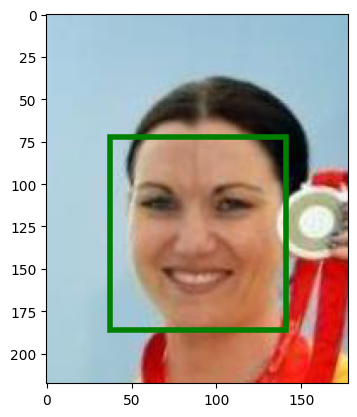

In [ ]:
plotting_image_with_box(3)

**Preparing data**

In [ ]:
df = df_org.copy()
df.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000009.jpg,68,113,110,111,97,139,66,152,109,150
1,000010.jpg,68,111,108,112,89,136,70,151,107,151
2,000014.jpg,68,112,109,111,92,141,72,150,104,152


In [ ]:
# Reduce image size for faster analysis
def rescale_key_points(oldsize=original_image_size, newsize=image_size_training):
    x_axis_old = oldsize[0]
    y_axis_old = oldsize[1]
    x_axis_new = newsize[0]
    y_axis_new = newsize[1]
    x_ratio = x_axis_new / x_axis_old
    y_ratio = y_axis_new / y_axis_old
    keypoints_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
    keypoints_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']
    df[keypoints_x] = (df[keypoints_x] * x_ratio).astype('int')
    df[keypoints_y] = (df[keypoints_y] * y_ratio).astype('int')
    return 0

rescale_key_points()
df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000009.jpg,38,41,61,41,54,51,37,56,61,55
1,000010.jpg,38,41,60,41,50,50,39,56,60,56
2,000014.jpg,38,41,61,41,51,52,40,55,58,56
3,000017.jpg,37,41,61,41,48,51,37,55,62,56
4,000018.jpg,37,41,61,41,49,50,38,55,61,55


In [ ]:
images=images_data
labels=df

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#test, train split
train_images,test_images,train_labels,test_labels=train_test_split(images,labels,test_size=0.3,random_state=42)

In [ ]:
X_test=test_images
X_train=train_images

In [ ]:
data_loader = torch.utils.data.DataLoader(X_train, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(X_test, batch_size=2, collate_fn=collate_fn)

**Model**

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 227MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')


----------------------train start--------------------------
epoch : 1, Loss : 77.14759063720703, time : 252.42370867729187
epoch : 2, Loss : 48.91315460205078, time : 263.22984743118286
epoch : 3, Loss : 43.18947982788086, time : 264.4591932296753
epoch : 4, Loss : 36.07373046875, time : 265.2568733692169
epoch : 5, Loss : 31.8864688873291, time : 265.57766008377075
epoch : 6, Loss : 31.76308250427246, time : 265.0076003074646
epoch : 7, Loss : 31.24744415283203, time : 265.16882514953613
epoch : 8, Loss : 29.340274810791016, time : 265.73448038101196
epoch : 9, Loss : 25.922008514404297, time : 267.91367626190186
epoch : 10, Loss : 23.59230613708496, time : 266.9004054069519



**Prediction**

In [ ]:
def predictions_test_model(index):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]

    # convert to the original size
    x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
    y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])

    points_list[0] = int(points_list[0] * x_ratio)
    points_list[2] = int(points_list[2] * x_ratio)
    points_list[4] = int(points_list[4] * x_ratio)
    points_list[6] = int(points_list[6] * x_ratio)
    points_list[8] = int(points_list[8] * x_ratio)

    points_list[1] = int(points_list[1] * y_ratio)
    points_list[3] = int(points_list[3] * y_ratio)
    points_list[5] = int(points_list[5] * y_ratio)
    points_list[7] = int(points_list[7] * y_ratio)
    points_list[9] = int(points_list[9] * y_ratio)

    return points_list

In [ ]:
# function to plot box around the faces
def test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='bo-' ,boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}".format(images_data_path, index),target_size=(y_org,x_org,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255

    # predictions of key points on the face
    if pred_or_actual == 'pred':
        points_list = predictions_test_model(index)        # this for predections of the model
    elif pred_or_actual == 'actual':
        points_list = image_key_points_list(index)   # this for the actual labels of the test data

    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]
    fig, ax = plt.subplots()
    ax.imshow(test_image)
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)

    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

RED box for predections



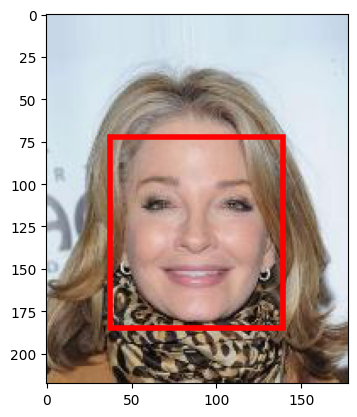

In [ ]:
import random
max_num=len(test_labels['image_id'])
image_index=random.randint(0, max_num)
index = test_labels['image_id'][image_index]
print('RED box for predections\n')
test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='mo-' ,boxcolor='r')

# **2. Extract the skin color**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

**Crop the image**

In [ ]:
def crop_image(index):
  img = tf.keras.preprocessing.image.load_img("{}".format(images_data_path, index),target_size=(y_org,x_org,3))
  img2 = tf.keras.preprocessing.image.img_to_array(img)
  test_image = img2/255

  points_list = predictions_test_model(index)
  le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
  lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]
  width = abs(le_x-rm_x)
  height = abs(le_y-rm_y+20)
  cropped_image=img2[le_x:le_x+width, le_y-40:le_y-40+height]
  cv2_imshow(img2)
  cv2_imshow(cropped_image)
  return(cropped_image)

In [ ]:
cutimage= crop_image(image_index)

1/1 [==============================] - 0s 33ms/step


**Calculate the luminance of the skin**

In [ ]:
imagecv = cv2.cvtColor(cutimage, cv2.COLOR_BGR2RGB)

In [ ]:
def print_luminance(image):
  Red = []
  Green = []
  Blue = []

  for x in image:
    for y in x:
        Red.append(y[0])
        Green.append(y[1])
        Blue.append(y[2])

  R_avg = sum(Red) / len(Red)
  G_avg = sum(Green) / len(Green)
  B_avg = sum(Blue) / len(Blue)
  luminance= 0.2126 * R_avg + 0.7152 * G_avg + 0.0722 * B_avg

  print("Avg Value")
  print("R : ", R_avg)
  print("G : ", G_avg)
  print("B : ", B_avg)
  print("Luminance: ",luminance )
  return(luminance)

In [ ]:
print_luminance(imagecv)

Avg Value
R :  164.68077601410934
G :  179.6851851851852
B :  211.89770723104056
Luminance:  178.82099188712522


178.82099188712522